In [1]:
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
df = pd.read_csv("../data/economy/econ_metrics.csv")
df.shape

(96, 6)

In [3]:
df.head()

,Date,Fed Rate,unemployment,sp500,nasdaq,bitcoin
0,2014-09-01,0.09,5.9,1993.226190,4543.620019,365.504008
1,2014-10-01,0.09,5.7,1937.274348,4412.285156,362.172752
2,2014-11-01,0.09,5.8,2044.572105,4706.417481,374.191498
3,2014-12-01,0.12,5.6,2054.266364,4746.681934,325.800800
4,2015-01-01,0.11,5.7,2028.178500,4682.892456,239.172253


In [5]:
df = df.set_index("Date")

In [6]:
columns = ["sp500", "nasdaq", "bitcoin"]
df[columns] = (df[columns] - df[columns].mean()) / df[columns].std()

In [7]:
df.head()

,Fed Rate,unemployment,sp500,nasdaq,bitcoin
Date,,,,,
2014-09-01,0.09,5.9,-1.117986,-1.107527,-0.745027
2014-10-01,0.09,5.7,-1.186684,-1.146440,-0.745230
2014-11-01,0.09,5.8,-1.054943,-1.059293,-0.744497
2014-12-01,0.12,5.6,-1.043040,-1.047364,-0.747449
2015-01-01,0.11,5.7,-1.075071,-1.066263,-0.752733


<AxesSubplot:xlabel='Date'>

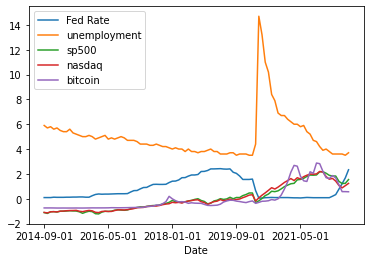

In [8]:
df.plot()